# Importing Libraries

In [3]:
import pandas as pd
import random
import numpy as np
import matplotlib.pyplot as plt
import datetime
import seaborn as sns

In [4]:
%run "Stock Data.ipynb".ipynb
%run "Binance API.ipynb".ipynb
%run "RiskMetrics.ipynb".ipynb
%run "PnL Computation.ipynb".ipynb

# Importing Data

## Tickers

In [5]:
binance_api_key='E90xR7UnO2oeP3lrgC50zkqUuAqyyXs4uSlAGcqIVO9n90ELrFI4gfVI2HGGxxCj'
binance_api_secret='Inls2xYl9FqPi0zlIrucfxG81drx7w6Pv6SzYFxMNoAcwDjlCKug7zUM9zB3lF9h'
Binance=BinanceAPI(binance_api_key,binance_api_secret)

In [6]:
#stocks=pd.read_html('https://en.wikipedia.org/wiki/EURO_STOXX_50')[4]
#tickers=stocks['Ticker'].to_list()

## Market Data

In [7]:
start_date=datetime.datetime(2023,12,1)
enddate=start_date+datetime.timedelta(500)

In [8]:
quantities_api=Binance.binance_api.user_asset()
current_quantities=pd.DataFrame(quantities_api).sort_values(by='free',ascending=False)
current_quantities['asset']=current_quantities['asset']+'USDT'
current_quantities=current_quantities.set_index('asset')

In [9]:
#today_price=Binance.get_price(holding_tickers,date=datetime.datetime.today()).T
#today_price.columns=['Mark To Market']

In [10]:
trade_history=pd.read_excel('Trade History Reconstructed.xlsx')
price=get_trade_in_usdt(trade_history)

In [11]:
book_cost=get_book_cost(price)
realized_pnl,profit_and_loss=get_pnl(book_cost,price)
historical_positions=get_historical_positions(price)
historical_positions.columns=historical_positions.columns+'USDT'
historical_positions=historical_positions.sort_index()

In [12]:
price_of_positions=Binance.get_price(historical_positions.columns,datetime.datetime(2024,5,1))
price_of_positions.index=pd.to_datetime(price_of_positions.index)
price_of_positions=price_of_positions.sort_index()

In [13]:
dic={}
for key in profit_and_loss:
    dic[key]=profit_and_loss[key].to_dict()

In [14]:
realized_pnl_time=pd.DataFrame(dic).sort_index().ffill().fillna(0)
realized_pnl_time.index=pd.to_datetime(realized_pnl_time.index).round(freq='d')
realized_pnl_time=realized_pnl_time.groupby(realized_pnl_time.index).sum()

In [15]:
tickers=Binance.get_market_cap()['Ticker'].iloc[:75].to_list()
holding=Binance.get_inventory()
condition=holding.index!='Total'
holding_tickers=holding.index[condition]
holding_tickers=holding_tickers.to_list()
tickers=sorted(list(set(tickers+holding_tickers)))
last_book_cost=book_cost.iloc[-1]
pnl=pd.concat([last_book_cost,holding.loc[condition],realized_pnl],axis=1)
pnl.columns=['Book Cost','Price in USDT','Weights','Realized PnL']
pnl['Book Cost']=(pnl['Book Cost']*current_quantities['free'].astype(float))
pnl['Unrealized PnL']=(pnl['Price in USDT']-pnl['Book Cost']).round(2)
pnl=pnl.fillna(0)
pnl['Weights']=pnl['Weights'].round(4)
pnl['Total PnL']=pnl['Unrealized PnL']+pnl['Realized PnL']
pnl.loc['Total']=pnl.sum()
pnl.sort_values(ascending=False,by='Price in USDT')

,Book Cost,Price in USDT,Weights,Realized PnL,Unrealized PnL,Total PnL
Total,2184.935036,3938.746216,1.0000,-131.886217,1753.82,1621.933783
OMUSDT,526.319895,1801.362305,0.4573,0.000000,1275.04,1275.040000
BTCUSDT,601.021649,868.029628,0.2204,3.537078,267.01,270.547078
JASMYUSDT,387.458505,493.933939,0.1254,0.000000,106.48,106.480000
SOLUSDT,281.200518,359.431452,0.0913,0.000000,78.23,78.230000
ETHUSDT,250.747339,240.677565,0.0611,0.000000,-10.07,-10.070000
TRXUSDT,76.868953,124.307956,0.0316,-10.723889,47.44,36.716111
BBUSDT,60.176053,49.812778,0.0126,-39.733101,-10.36,-50.093101
BNBUSDT,1.142121,1.190588,0.0003,-10.606040,0.05,-10.556040
PEPEUSDT,0.000004,0.000005,0.0000,-38.521986,0.00,-38.521986


In [16]:
data1=Binance.get_price(tickers,start_date)
data2=Binance.get_price(tickers,enddate)
data=data1.combine_first(data2)
data.index=pd.to_datetime(data.index)
#data=data.dropna(axis=1)
n=len(data.columns)
data=data.sort_index()

In [17]:
inventory_weights=(holding['Weights'].apply(lambda x: np.round(x,2))).to_dict()
inventory_weights.pop('Total')

if "USDTUSDT" in inventory_weights:
    
    inventory_weights.pop('USDTUSDT')
else: 
    pass

In [18]:
returns=np.log(1+data.pct_change())
returns.index=pd.to_datetime(returns.index)
with_no_na=returns.columns[np.where((returns.isna().sum()<30))]
returns_to_use=returns[with_no_na]
ex_ante_perf=returns[holding_tickers]
ex_ante_perf_to_use=ex_ante_perf.dropna()

In [19]:
weights_post=dict()

for col in ex_ante_perf.columns:
    
    if col in inventory_weights.keys():
        weights_post[col]=inventory_weights[col]
        
    else:
        weights_post[col]=0
    
current_weights=np.array(list(weights_post.values()))
current_weights=np.round(current_weights,2)/np.sum(np.round(current_weights,2))

## Positions, Historical Performance and PnL

In [20]:
position=pd.read_excel('Positions.xlsx',index_col=0)

positions,quantities=Binance.get_positions_history(enddate=datetime.datetime.today())
positions=positions.sort_index()

positions.index=pd.to_datetime(positions.index)
positions=pd.concat([position,positions])
positions=positions.loc[~positions.index.duplicated(),:]

positions.to_excel('Positions.xlsx')

positions=positions.interpolate()
positions['Total']=positions.sum(axis=1)

In [21]:
quantities_history=pd.read_excel('Quantities.xlsx',index_col=0)

quantities.index=pd.to_datetime(quantities.index)

quantities=pd.concat([quantities,quantities_history])
quantities=quantities.loc[~quantities.index.duplicated(),:]
quantities=quantities.sort_index()

quantities.to_excel('Quantities.xlsx')

quantities_tickers=list(quantities.columns)

In [22]:
price_pnl=Binance.get_price(quantities_tickers,date=quantities.index[0])

In [23]:
price_pnl.index=pd.to_datetime(price_pnl.index)
pnl_history=pd.DataFrame()
pnl_history.index=quantities.index
pnl_history=pnl_history.sort_index()
for col in quantities:
    
    pnl_history[col]=quantities[col]*(price_pnl[col]-book_cost.iloc[-1][col])

pnl_history['Total']=pnl_history.sum(axis=1) +realized_pnl.sum()[0]

C:\Users\niroo\AppData\Local\Temp\ipykernel_33160\1175112299.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pnl_history['Total']=pnl_history.sum(axis=1) +realized_pnl.sum()[0]


In [24]:
pnl_history['Total']-pnl_history['Total'].shift(1)

2024-09-23           NaN
2024-09-24     23.503339
2024-09-25     -7.470131
2024-09-26     85.699217
2024-09-27     16.519121
                 ...    
2024-12-19    -88.900304
2024-12-20    -38.777002
2024-12-21   -150.441057
2024-12-22    -14.543135
2024-12-23    105.666671
Name: Total, Length: 92, dtype: float64

In [25]:
pnl_history['Total']

2024-09-23    -378.365173
2024-09-24    -354.861834
2024-09-25    -362.331965
2024-09-26    -276.632747
2024-09-27    -260.113627
                 ...     
2024-12-19    1584.446430
2024-12-20    1545.669428
2024-12-21    1395.228371
2024-12-22    1380.685236
2024-12-23    1486.351906
Name: Total, Length: 92, dtype: float64

In [26]:
#eurusd=Binance.get_price(['EURUSDT'],date=pnl_history.index[0])

In [27]:
ptf_tickers=list(positions.columns)
ptf_tickers.remove('USDTUSDT')

In [28]:
weights_ex_post=positions.copy()
weights_ex_post=weights_ex_post.drop(columns=['USDTUSDT'])
weights_ex_post=weights_ex_post.apply(lambda x: x/weights_ex_post['Total'])

In [29]:
binance_data=Binance.get_price(ptf_tickers,date=datetime.datetime(2024,5,11))
binance_data.index=pd.to_datetime(binance_data.index)
binance_data=binance_data.sort_index()
binance_data=np.log(1+binance_data.pct_change())


LDUMAUSDT not retrieved
Total not retrieved


C:\Users\niroo\AppData\Local\Temp\ipykernel_33160\974280261.py:4: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  binance_data=np.log(1+binance_data.pct_change())


In [30]:
weight_date=set(weights_ex_post.index)
binance_date=binance_data.index

In [31]:
common_date=binance_date.intersection(weight_date)

binance_data=binance_data.loc[common_date]

In [32]:
historical_ptf=pd.DataFrame()

for col in binance_data:
    historical_ptf[col]=weights_ex_post[col]*binance_data[col]
    
historical_ptf['Historical Portfolio']=historical_ptf.sum(axis=1)

<Axes: >

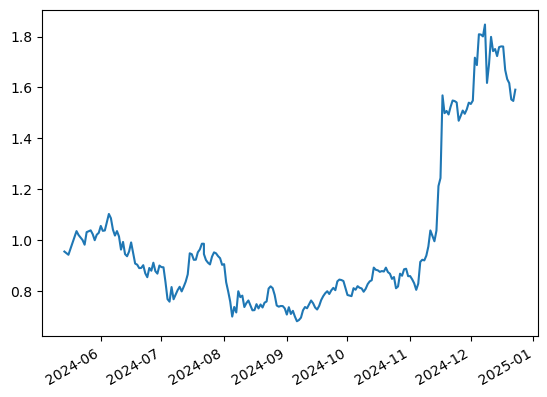

In [33]:
#historical_ptf.dropna(axis = 0, how = 'all', inplace = True)

(1+historical_ptf['Historical Portfolio']).cumprod().plot()

## Ex ante data

In [34]:
ex_ante_ptf=ex_ante_perf.copy()

for key in inventory_weights.keys():
    
    ex_ante_ptf[key]=ex_ante_perf[key]*inventory_weights[key]

ex_ante_ptf=pd.DataFrame(ex_ante_ptf.sum(axis=1))

# Portfolio Optimization

## Class set up

In [35]:
historical_risk=RiskAnalysis(returns_to_use)
current_risk=RiskAnalysis(ex_ante_perf_to_use.iloc[:])
num_asset=len(returns_to_use.columns)
num_asset_current=len(ex_ante_perf_to_use.columns)

In [36]:
returns_to_use.columns

Index(['AAVEUSDT', 'ADAUSDT', 'ALGOUSDT', 'APTUSDT', 'ARBUSDT', 'ARUSDT',
       'ATOMUSDT', 'AVAXUSDT', 'BCHUSDT', 'BNBUSDT', 'BONKUSDT', 'BTCUSDT',
       'CRVUSDT', 'DOGEUSDT', 'DOTUSDT', 'ENSUSDT', 'EOSUSDT', 'ETCUSDT',
       'ETHUSDT', 'FDUSDUSDT', 'FETUSDT', 'FILUSDT', 'FLOKIUSDT', 'FLOWUSDT',
       'FTMUSDT', 'GALAUSDT', 'GRTUSDT', 'HBARUSDT', 'ICPUSDT', 'IMXUSDT',
       'INJUSDT', 'IOTAUSDT', 'JASMYUSDT', 'LDOUSDT', 'LINKUSDT', 'LTCUSDT',
       'MKRUSDT', 'NEARUSDT', 'OMUSDT', 'OPUSDT', 'PEPEUSDT', 'QNTUSDT',
       'RAYUSDT', 'RUNEUSDT', 'SANDUSDT', 'SEIUSDT', 'SHIBUSDT', 'SOLUSDT',
       'STXUSDT', 'SUIUSDT', 'THETAUSDT', 'TIAUSDT', 'TRXUSDT', 'UNIUSDT',
       'USDCUSDT', 'VETUSDT', 'WBETHUSDT', 'WBTCUSDT', 'WLDUSDT', 'XLMUSDT',
       'XRPUSDT', 'XTZUSDT'],
      dtype='object')

In [37]:
cash=np.where(returns_to_use.columns=='USDCUSDT')[0][0],np.where(returns_to_use.columns=='FDUSDUSDT')[0][0]
limit_hist=np.where(returns_to_use.columns=='BTCUSDT')[0][0],np.where(returns_to_use.columns=='ETHUSDT')[0][0],np.where(returns_to_use.columns=='SOLUSDT')[0][0],np.where(returns_to_use.columns=='USDCUSDT')[0][0]

## Optimal Portfolio

### Historical results

In [38]:
opt_weights=historical_risk.optimize(objective="sharpe_ratio",constraints=[{'type': 'eq', 'fun': lambda weights: weights[cash[0]]-0.00},
                                                                              
                                                                              {'type': 'eq', 'fun': lambda weights: weights[cash[1]]-0.00}])
inventory=historical_risk.inventory(opt_weights)
inventory.columns=['Optimal Weights']

inventory.iloc[:10].round(4)

,Optimal Weights
OMUSDT,0.4099
BNBUSDT,0.1954
SUIUSDT,0.1128
PEPEUSDT,0.1109
XRPUSDT,0.0832
TRXUSDT,0.0445
JASMYUSDT,0.0187
XLMUSDT,0.0153
AAVEUSDT,0.0090
ADAUSDT,0.0004


In [39]:
opt_weights=historical_risk.optimize(objective="sharpe_ratio",constraints=[{'type': 'ineq', 'fun': lambda weights: weights[limit_hist[0]]-0.30}])
                                                         #  ,{'type': 'ineq', 'fun': lambda weights: weights[limit[1]]-0.15},
                                                        #{'type': 'ineq', 'fun': lambda weights: weights[limit[2]]-0.15}])
opt_weights=np.round(opt_weights,6)
inventory=historical_risk.inventory(opt_weights)
inventory.columns=['Optimal Weights']

inventory

,Optimal Weights
OMUSDT,0.388607
BTCUSDT,0.300000
SUIUSDT,0.092971
PEPEUSDT,0.075138
BNBUSDT,0.057319
TRXUSDT,0.035564
XRPUSDT,0.034853
JASMYUSDT,0.009924
XLMUSDT,0.005624


### Current results

In [40]:
limit=np.where(ex_ante_perf_to_use.columns=='BTCUSDT')[0][0],np.where(ex_ante_perf_to_use.columns=='ETHUSDT')[0][0],np.where(ex_ante_perf_to_use.columns=='SOLUSDT')[0][0]

In [41]:
current_optimal_weights=current_risk.optimize(objective="sharpe_ratio")#,constraints=[{'type': 'ineq', 'fun': lambda weights: weights[limit[0]]-0.40}])
                                                           #,{'type': 'ineq', 'fun': lambda weights: weights[limit[1]]-0.15},
                                                            #{'type': 'ineq', 'fun': lambda weights: weights[limit[2]]-0.15}])
current_optimal_weights=np.round(current_optimal_weights,6)
optimal_ptf_current=current_risk.inventory(current_optimal_weights)
optimal_ptf_current.columns=['Optimal Weights']
optimal_ptf_current

,Optimal Weights
BTCUSDT,0.438280
OMUSDT,0.391525
TRXUSDT,0.170195


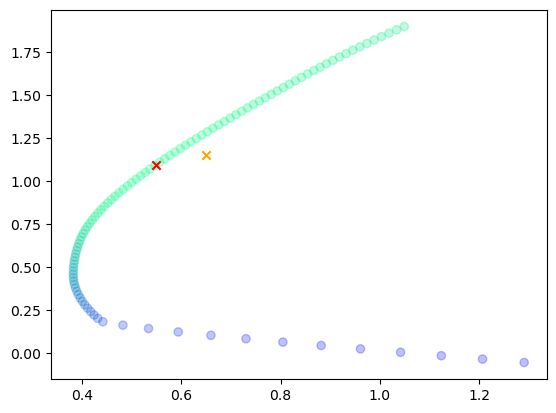

In [42]:
X,Y,Z,C=current_risk.efficient_frontier()

opt_res=current_risk.performance(current_optimal_weights),current_risk.variance(current_optimal_weights)
current_res=current_risk.performance(current_weights),current_risk.variance(current_weights)

plt.scatter(Z,Y,c=C,cmap="winter",alpha=0.25,marker='o')
plt.scatter(opt_res[1],opt_res[0],c='red',marker='x')
plt.scatter(current_res[1],current_res[0],c='orange',marker='x')

## Real Portfolio vs Optimal

In [43]:
current_holding_comparison=holding.copy()
current_holding_comparison=current_holding_comparison.loc[current_holding_comparison.index!="Total"]
current_holding_comparison=pd.concat([current_holding_comparison,optimal_ptf_current],axis=1)
current_holding_comparison['Spread']=current_holding_comparison['Weights']-current_holding_comparison['Optimal Weights']
current_holding_comparison['Weights']=current_holding_comparison['Weights'].round(7)
current_holding_comparison=current_holding_comparison.fillna(0)
current_holding_comparison

,Price in USDT,Weights,Optimal Weights,Spread
OMUSDT,1801.362305,0.457344,0.391525,0.065819
BTCUSDT,868.029628,0.220382,0.438280,-0.217898
JASMYUSDT,493.933939,0.125404,0.000000,0.000000
SOLUSDT,359.431452,0.091255,0.000000,0.000000
ETHUSDT,240.677565,0.061105,0.000000,0.000000
TRXUSDT,124.307956,0.031560,0.170195,-0.138635
BBUSDT,49.812778,0.012647,0.000000,0.000000
BNBUSDT,1.190588,0.000302,0.000000,0.000000
PEPEUSDT,0.000005,0.000000,0.000000,0.000000


In [44]:
historical_comparison=holding.copy()
historical_comparison=historical_comparison.loc[historical_comparison.index!="Total"]
historical_comparison=pd.concat([historical_comparison,inventory],axis=1)
historical_comparison['Spread']=historical_comparison['Weights']-historical_comparison['Optimal Weights']
historical_comparison['Weights']=historical_comparison['Weights'].round(7)
historical_comparison=historical_comparison.fillna(0)
historical_comparison

,Price in USDT,Weights,Optimal Weights,Spread
OMUSDT,1801.362305,0.457344,0.388607,0.068737
BTCUSDT,868.029628,0.220382,0.300000,-0.079618
JASMYUSDT,493.933939,0.125404,0.009924,0.115480
SOLUSDT,359.431452,0.091255,0.000000,0.000000
ETHUSDT,240.677565,0.061105,0.000000,0.000000
TRXUSDT,124.307956,0.031560,0.035564,-0.004004
BBUSDT,49.812778,0.012647,0.000000,0.000000
BNBUSDT,1.190588,0.000302,0.057319,-0.057017
PEPEUSDT,0.000005,0.000000,0.075138,-0.075138
SUIUSDT,0.000000,0.000000,0.092971,0.000000


# Risk Reward Analysis

In [45]:
opt_ptf=(returns_to_use*opt_weights).sum(axis=1)
curr_opt_ptf=(ex_ante_perf*current_optimal_weights).sum(axis=1)
portfolio_perf=pd.DataFrame()
portfolio_perf['Portfolio']=(ex_ante_perf*current_weights).sum(axis=1)

In [46]:
portfolio_perf['Bitcoin']=returns['BTCUSDT']
portfolio_perf['Optimal']=opt_ptf
portfolio_perf['Current Optimal']=curr_opt_ptf

<Axes: >

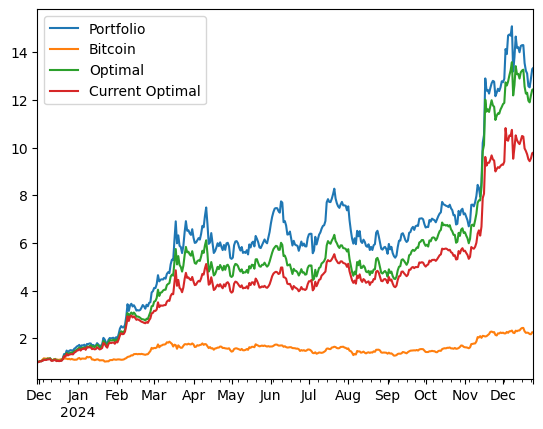

In [47]:
(1+portfolio_perf.loc[:]).cumprod().plot()

In [48]:
current_perf=portfolio_perf.copy()
current_perf=current_perf.loc[historical_ptf.index]
current_perf['Historical Portfolio']=historical_ptf['Historical Portfolio']

<Axes: >

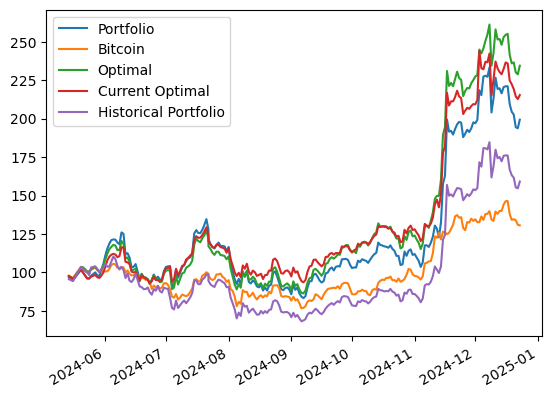

In [49]:
((1+current_perf).cumprod()*100).plot()

In [50]:
((1+current_perf).cumprod()*100).iloc[-10:]

,Portfolio,Bitcoin,Optimal,Current Optimal,Historical Portfolio
2024-12-14,216.484813,140.010643,248.051923,228.894504,172.317363
2024-12-15,220.550637,144.151053,253.033151,232.346235,175.836410
2024-12-16,221.069116,146.334930,254.520917,236.581227,176.121825
2024-12-17,221.103255,146.438485,255.184001,235.950952,176.070219
2024-12-18,209.464340,138.019474,241.549267,224.818817,166.879687
2024-12-19,204.522440,134.189836,235.951571,222.403867,163.265422
2024-12-20,202.673000,134.662061,236.576739,219.244564,161.692923
2024-12-21,194.448081,133.953262,230.150167,214.555072,155.314800
2024-12-22,193.752682,131.022237,228.843164,212.734243,154.715129
2024-12-23,199.350425,130.602012,234.448427,215.342299,159.135218


## Volatilities

In [51]:
vol=historical_risk.portfolio(opt_weights).std()*np.sqrt(252)
vol_ex_ante=historical_risk.variance(opt_weights)

vol,vol_ex_ante

(Portfolio    0.645713
 dtype: float64,
 0.6465138421857953)

In [52]:
vol=current_risk.portfolio(current_weights).std()*np.sqrt(252)
vol_ex_ante=current_risk.variance(current_weights)
vol,vol_ex_ante

(Portfolio    0.650447
 dtype: float64,
 0.6504474733679738)

In [53]:
portfolio_perf.iloc[1:].std()*np.sqrt(252)

Portfolio          0.725187
Bitcoin            0.433927
Optimal            0.646514
Current Optimal    0.614491
dtype: float64

In [54]:
current_risk.tracking_error(current_risk.returns['BTCUSDT'],current_perf['Historical Portfolio'])

0.4592608895711062

## Risk Contribution

In [55]:
perf_analysis=pd.concat([historical_risk.perf_contrib(opt_weights),historical_risk.var_contrib_pct(opt_weights)],axis=1)
perf_analysis

,Performance Contribution,Initial Weights,Last Weights,Variance Contribution in %,Idiosyncratic Risk in %,Correlation in %
BNBUSDT,0.090337,0.057319,0.006762,0.020163,0.001804,0.018359
BTCUSDT,0.374222,0.300000,0.030877,0.130292,0.040543,0.089749
JASMYUSDT,0.020832,0.009924,0.001409,0.006747,0.000300,0.006447
OMUSDT,19.659853,0.388607,0.918138,0.681148,0.578058,0.103090
PEPEUSDT,0.330906,0.075138,0.018595,0.072317,0.021580,0.050737
SUIUSDT,0.264111,0.092971,0.016353,0.062542,0.019047,0.043496
TRXUSDT,0.028937,0.035564,0.002954,0.009806,0.001437,0.008370
XLMUSDT,0.006685,0.005624,0.000564,0.002142,0.000045,0.002097
XRPUSDT,0.060121,0.034853,0.004349,0.014843,0.001272,0.013570


In [56]:
perf_analysis=pd.concat([current_risk.perf_contrib(current_optimal_weights),current_risk.var_contrib_pct(current_optimal_weights)],axis=1)
perf_analysis

,Performance Contribution,Initial Weights,Last Weights,Variance Contribution in %,Idiosyncratic Risk in %,Correlation in %
OMUSDT,0.978538,0.391525,0.604818,0.678841,0.560333,0.118508
BTCUSDT,0.195242,0.438280,0.279670,0.197798,0.108111,0.089686
TRXUSDT,0.091467,0.170195,0.115512,0.123362,0.072992,0.050369


In [57]:
perf_analysis=pd.concat([current_risk.perf_contrib(current_weights),current_risk.var_contrib_pct(current_weights)],axis=1)
perf_analysis

,Performance Contribution,Initial Weights,Last Weights,Variance Contribution in %,Idiosyncratic Risk in %,Correlation in %
OMUSDT,1.149677,0.46,0.698291,0.672554,0.550656,0.121898
BTCUSDT,0.098004,0.22,0.137953,0.086246,0.019393,0.066853
JASMYUSDT,0.033234,0.13,0.070812,0.129585,0.048200,0.081386
SOLUSDT,0.011679,0.09,0.044109,0.061995,0.007998,0.053997
ETHUSDT,0.001863,0.06,0.026837,0.027524,0.002551,0.024973
TRXUSDT,0.016123,0.03,0.020008,0.011815,0.001615,0.010201
BBUSDT,-0.005413,0.01,0.001990,0.010280,0.000394,0.009886


# Value At Risk

## Historical

### Optimal Weights

In [58]:
var,cvar=historical_risk.historical_var(opt_weights)
(var,cvar)

(-0.05204908268686992, -0.07550197530548508)

### Current Weights

In [59]:
var,cvar=current_risk.historical_var(current_weights)
(var,cvar)

(-0.04903325845607954, -0.07348827587878122)

In [60]:
historical_var=current_risk.returns*current_weights
historical_var['Portfolio']=historical_var.sum(axis=1)
historical_var=historical_var.sort_values(by='Portfolio')
centile=0.05
row=round(historical_var.shape[0]*centile)

In [61]:
var=historical_var.iloc[row]
var

OMUSDT      -0.034123
BTCUSDT     -0.002054
JASMYUSDT   -0.007219
SOLUSDT     -0.002769
ETHUSDT     -0.001657
TRXUSDT     -0.000430
BBUSDT      -0.001246
BNBUSDT     -0.000000
PEPEUSDT    -0.000000
Portfolio   -0.049497
Name: 2024-07-22 00:00:00, dtype: float64

In [62]:
cvar=historical_var.iloc[:row+1].mean()
cvar

OMUSDT      -0.042878
BTCUSDT     -0.007705
JASMYUSDT   -0.012021
SOLUSDT     -0.006128
ETHUSDT     -0.002861
TRXUSDT     -0.000974
BBUSDT      -0.000922
BNBUSDT      0.000000
PEPEUSDT     0.000000
Portfolio   -0.073488
dtype: float64

## Parametric

### Optimal Weights

In [63]:
var,cvar=historical_risk.parametric_var(opt_weights)

(var,cvar)

(-0.06698920351699902, -0.08586163741980081)

### Current Weights

In [64]:
var,cvar=current_risk.parametric_var(current_weights)

(var,cvar)

(-0.06739679079917209, -0.08638405162390439)

## Multivariate

### Optimal Weights

In [65]:
perf=performance(historical_risk.multivariate_distribution(),opt_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()
(var,cvar)

(-0.0607807015482029, -0.0774879499566936)

### Current Weights

In [66]:
perf=performance(current_risk.multivariate_distribution(),current_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()
(var,cvar)

(-0.06200388528884734, -0.07850541716750806)

In [67]:
scenario_multivariate={}

for i in range(50):
    multivariate_distrib=pd.DataFrame(current_risk.multivariate_distribution(),columns=current_risk.returns.columns)
    multivariate_distrib=multivariate_distrib*current_weights
    multivariate_distrib=multivariate_distrib[multivariate_distrib.columns[current_weights>0]]

    multivariate_distrib['Portfolio']=multivariate_distrib.sum(axis=1)
    multivariate_var=multivariate_distrib.sort_values(by='Portfolio').iloc[int(multivariate_distrib.shape[0]*0.05)]['Portfolio']
    results=multivariate_distrib.sort_values(by='Portfolio').iloc[int(multivariate_distrib.shape[0]*0.05)]

    scenario_multivariate[i]=results.to_dict()

mean_scenario_multivariate=pd.DataFrame(scenario_multivariate).T.mean()
mean_scenario_multivariate

OMUSDT      -0.041322
BTCUSDT     -0.005402
JASMYUSDT   -0.008475
SOLUSDT     -0.004351
ETHUSDT     -0.001973
TRXUSDT     -0.000551
BBUSDT      -0.000667
Portfolio   -0.062742
dtype: float64

## Copulas

## Gaussian Copula

### Optimal Weights

In [68]:
cop=historical_risk.gaussian_copula()
perf=performance(cop,opt_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.05939983599788442, -0.07530863666352017)

### Current Weights

In [69]:
cop=current_risk.gaussian_copula()
perf=performance(cop,current_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.06346455304570868, -0.07934407761556085)

In [70]:
scenario_gaussian={}

for i in range(100):
    gaussian_copula_distrib=pd.DataFrame(current_risk.gaussian_copula(),columns=current_risk.returns.columns)

    gaussian_copula_distrib=gaussian_copula_distrib*current_weights
    gaussian_copula_distrib=gaussian_copula_distrib[gaussian_copula_distrib.columns[current_weights>0]]

    gaussian_copula_distrib['Portfolio']=gaussian_copula_distrib.sum(axis=1)
    gaussian_var=gaussian_copula_distrib.sort_values(by='Portfolio').iloc[int(gaussian_copula_distrib.shape[0]*0.05)]['Portfolio']
    results=gaussian_copula_distrib.sort_values(by='Portfolio').iloc[int(gaussian_copula_distrib.shape[0]*0.05)]
    
    scenario_gaussian[i]=results
    
mean_scenario_gaussian=pd.DataFrame(scenario_gaussian).T.mean()
mean_scenario_gaussian

OMUSDT      -0.038515
BTCUSDT     -0.006546
JASMYUSDT   -0.010081
SOLUSDT     -0.004237
ETHUSDT     -0.002025
TRXUSDT     -0.000583
BBUSDT      -0.000826
Portfolio   -0.062813
dtype: float64

## Student Copula

### Optimal Weights

In [71]:
t_copula=historical_risk.t_copula()
perf=performance(t_copula,opt_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.05992084103377547, -0.07643627761323131)

### Current Weights

In [72]:
t_copula=current_risk.t_copula()
perf=performance(t_copula,current_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.06491618961178032, -0.08404557827290116)

In [73]:
scenario_t_copula={}

for i in range(100):
    
    t_copula_distrib=pd.DataFrame(current_risk.t_copula(),columns=current_risk.returns.columns)
    t_copula_distrib=t_copula_distrib*current_weights
    t_copula_distrib=t_copula_distrib[t_copula_distrib.columns[current_weights>0]]
    t_copula_distrib['Portfolio']=t_copula_distrib.sum(axis=1)
    t_copula_var=t_copula_distrib.sort_values(by='Portfolio').iloc[int(t_copula_distrib.shape[0]*0.05)]['Portfolio']
    results=t_copula_distrib.sort_values(by='Portfolio').iloc[int(t_copula_distrib.shape[0]*0.05)]
    
    scenario_t_copula[i]=results
    
mean_scenario_gaussian=pd.DataFrame(scenario_t_copula).T.mean()
mean_scenario_gaussian

OMUSDT      -0.042170
BTCUSDT     -0.005683
JASMYUSDT   -0.008636
SOLUSDT     -0.004332
ETHUSDT     -0.001798
TRXUSDT     -0.000739
BBUSDT      -0.000747
Portfolio   -0.064104
dtype: float64

## Gumbel Copula

### Optimal Weights

In [74]:
gumbel_copula=historical_risk.gumbel_copula()
perf=performance(gumbel_copula,opt_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.1128242387553251, -0.16050344770536754)

### Current Weights

In [75]:
gumbel_copula=current_risk.gumbel_copula(theta=2)
perf=performance(gumbel_copula,current_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.11646306841105736, -0.16024422135108068)

In [76]:
scenario_gumbel_copula={}

for i in range(100):
    
    gumbel_copula_distrib=pd.DataFrame(current_risk.gumbel_copula(),columns=current_risk.returns.columns)
    gumbel_copula_distrib=gumbel_copula_distrib*current_weights
    gumbel_copula_distrib=gumbel_copula_distrib[gumbel_copula_distrib.columns[current_weights>0]]
    gumbel_copula_distrib['Portfolio']=gumbel_copula_distrib.sum(axis=1)
    gumbel_copula_var=gumbel_copula_distrib.sort_values(by='Portfolio').iloc[int(gumbel_copula_distrib.shape[0]*0.05)]['Portfolio']
    results=gumbel_copula_distrib.sort_values(by='Portfolio').iloc[int(gumbel_copula_distrib.shape[0]*0.05)]
    
    scenario_gumbel_copula[i]=results
    
mean_scenario_gaussian=pd.DataFrame(scenario_gumbel_copula).T.mean()
mean_scenario_gaussian

OMUSDT      -0.100718
BTCUSDT     -0.002167
JASMYUSDT   -0.008176
SOLUSDT     -0.001434
ETHUSDT      0.000669
TRXUSDT      0.000008
BBUSDT      -0.000081
Portfolio   -0.111899
dtype: float64

## Monte Carlo

### Optimal

In [77]:
spot=data[with_no_na].iloc[-1]
monte_carlo=historical_risk.monte_carlo(spot,horizon=1/250,stress_factor=1.0)
perf=performance(monte_carlo[1].fillna(0),opt_weights)

In [78]:
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.06716240252915968, -0.08538490740293254)

### Current Weights

In [79]:
spot=data[ex_ante_perf.columns].iloc[-1]
monte_carlo=current_risk.monte_carlo(spot,horizon=1/250,stress_factor=1.0)
perf=performance(monte_carlo[1].fillna(0),current_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.07060537198178846, -0.08799601023739596)

In [80]:
spot=data[ex_ante_perf.columns].iloc[-1]

scenario_monte_carlo={}

for i in range(100):
    
    monte_carlo=current_risk.monte_carlo(spot,horizon=1/250,stress_factor=1.0)
    monte_carlo_distrib=monte_carlo[1].fillna(0)*current_weights
    monte_carlo_distrib=monte_carlo_distrib[monte_carlo_distrib.columns[current_weights>0]]
    monte_carlo_distrib['Portfolio']=monte_carlo_distrib.sum(axis=1)
    monte_carlo_var=monte_carlo_distrib.sort_values(by='Portfolio').iloc[int(monte_carlo_distrib.shape[0]*0.05)]['Portfolio']
    results=monte_carlo_distrib.sort_values(by='Portfolio').iloc[int(monte_carlo_distrib.shape[0]*0.05)]
    
    scenario_monte_carlo[i]=results
    
mean_scenario_monte_carlo=pd.DataFrame(scenario_monte_carlo).T.mean()
mean_scenario_monte_carlo

OMUSDT      -0.045955
BTCUSDT     -0.006235
JASMYUSDT   -0.009231
SOLUSDT     -0.004237
ETHUSDT     -0.001998
TRXUSDT     -0.000537
BBUSDT      -0.000732
Portfolio   -0.068926
dtype: float64

## VaR Violation

In [81]:
var_data=rolling_var(returns_to_use,opt_weights,window=30,Q=1)
var_data

,Historical,Parametric,Multivariate,Portfolio
2024-01-14,-0.055768,-0.094996,-0.077390,-0.024418
2024-01-15,-0.055768,-0.095046,-0.078976,0.022501
2024-01-16,-0.055768,-0.094502,-0.075564,0.041611
2024-01-17,-0.055768,-0.096391,-0.079457,-0.028328
2024-01-18,-0.055768,-0.099263,-0.085203,-0.039430
...,...,...,...,...
2024-12-21,-0.088308,-0.077022,-0.076403,-0.027165
2024-12-22,-0.088308,-0.076581,-0.076326,-0.005679
2024-12-23,-0.088308,-0.076821,-0.075436,0.024494
2024-12-24,-0.088308,-0.077106,-0.074918,0.019101


In [82]:
current_var_data=rolling_var(ex_ante_perf_to_use,current_weights,window=15,Q=1)
current_var_data

,Historical,Parametric,Multivariate,Portfolio
2024-05-28,-0.035608,-0.084675,-0.082173,-0.017414
2024-05-29,-0.035608,-0.082053,-0.076301,-0.008786
2024-05-30,-0.035608,-0.072176,-0.067521,0.038472
2024-05-31,-0.035608,-0.073354,-0.066796,0.039857
2024-06-01,-0.035608,-0.077122,-0.067897,0.054157
...,...,...,...,...
2024-12-21,-0.115250,-0.103607,-0.114049,-0.040582
2024-12-22,-0.115250,-0.103597,-0.110874,-0.003576
2024-12-23,-0.115250,-0.103906,-0.113368,0.028891
2024-12-24,-0.050952,-0.074854,-0.074417,0.031159


<Axes: >

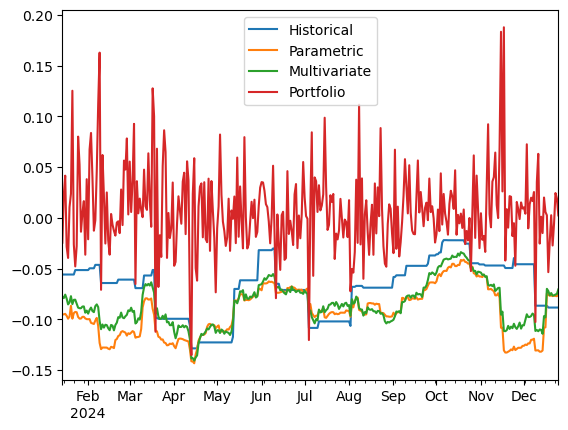

In [83]:
var_data.plot()

<Axes: >

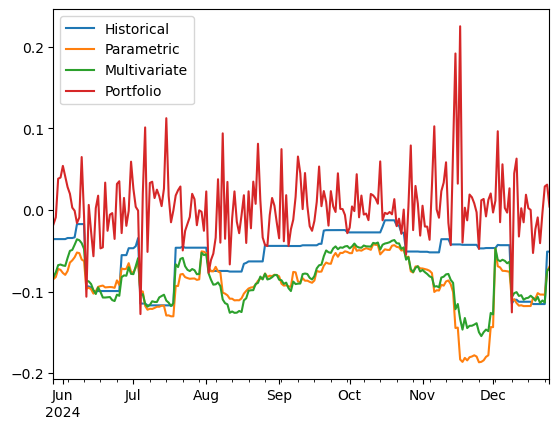

In [84]:
current_var_data.plot()

In [85]:
kupiec_test(var_data)

,Historical,Parametric,Multivariate
Proportion of failure,0.025937,0.011527,0.011527
Kupiec Stat,5.095118,15.495102,15.495102
P-value,0.023993,0.000083,0.000083


In [86]:
kupiec_test(current_var_data)

,Historical,Parametric,Multivariate
Proportion of failure,0.061321,0.018868,0.014151
Kupiec Stat,0.535193,5.617484,7.909801
P-value,0.464432,0.017782,0.004917


# Principal Component Analysis

## Historical PCA

In [87]:
eigval,eigvec,portfolio_components=historical_risk.pca(num_components=5)
variance_explained=eigval/eigval.sum()
variance_explained

array([0.77409904, 0.07213048, 0.05774376, 0.05192852, 0.04409821])

In [88]:
pca_weight=dict((portfolio_components['PC1']/portfolio_components['PC1'].sum()))
portfolio_components['PC1']

AAVEUSDT    0.015292
ADAUSDT     0.015535
ALGOUSDT    0.017503
APTUSDT     0.016264
ARBUSDT     0.017191
              ...   
WBTCUSDT    0.009263
WLDUSDT     0.022195
XLMUSDT     0.012341
XRPUSDT     0.010723
XTZUSDT     0.016266
Name: PC1, Length: 62, dtype: float64

<Axes: >

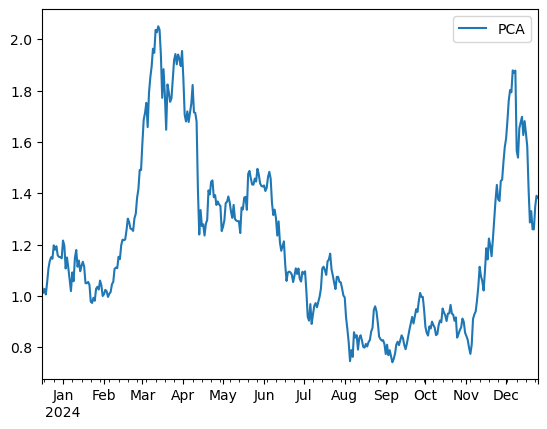

In [89]:
historical_PCA=pd.DataFrame(np.array(list(pca_weight.values())).dot(np.transpose(historical_risk.returns)),
                 index=historical_risk.returns.index,
                 columns=['PCA'])
historical_PCA=historical_PCA.dropna()
(1+historical_PCA).cumprod().plot()

<Axes: >

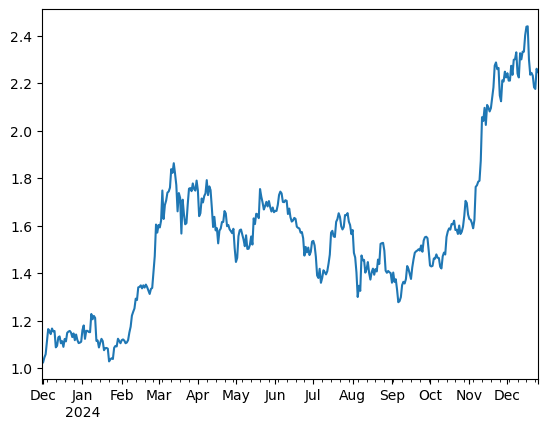

In [90]:
(1+historical_risk.returns['BTCUSDT']).cumprod().plot()

In [91]:
comparison=historical_risk.returns.copy()
comparison['PCA']=historical_PCA
distances=np.sqrt(np.sum(comparison.apply(lambda y:(y-historical_PCA['PCA'])**2))).sort_values()
distances

C:\Users\niroo\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


PCA          0.000000
FLOWUSDT     0.420471
WBETHUSDT    0.427533
ETHUSDT      0.427610
ATOMUSDT     0.450972
               ...   
FLOKIUSDT    1.129831
WLDUSDT      1.136602
BONKUSDT     1.137757
PEPEUSDT     1.184838
OMUSDT       1.543010
Length: 63, dtype: float64

<Axes: >

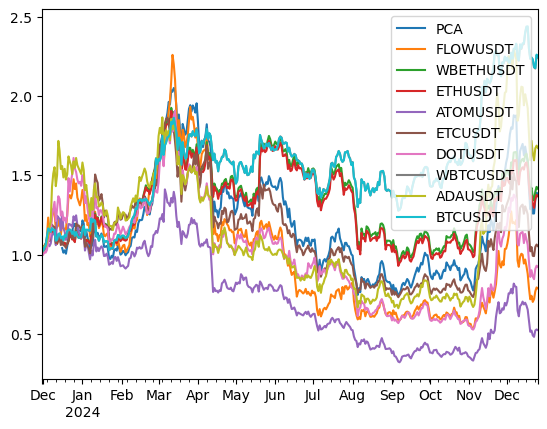

In [92]:
(1+comparison[distances.index[:10]]).cumprod().plot()

<Axes: >

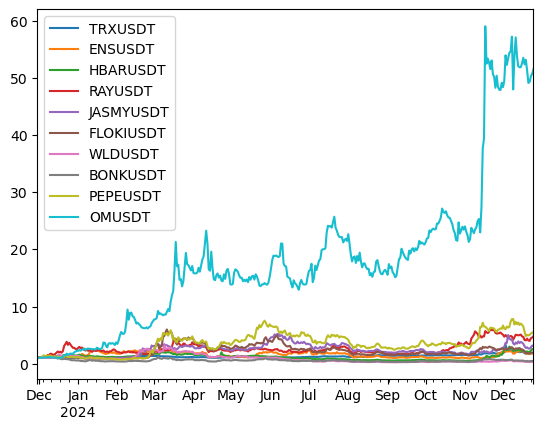

In [93]:
(1+comparison[distances.index[-10:]]).cumprod().plot()

## Current PCA

In [94]:
eigval,eigvec,portfolio_components_current=current_risk.pca(num_components=5)
variance_explained=eigval/eigval.sum()
variance_explained

array([0.54361501, 0.14964874, 0.13075724, 0.10190447, 0.07407453])

In [95]:
pca_weight=dict((portfolio_components_current['PC1']/portfolio_components_current['PC1'].sum()))
portfolio_components_current['PC1']

OMUSDT       0.095331
BTCUSDT      0.060927
JASMYUSDT    0.169994
SOLUSDT      0.101714
ETHUSDT      0.083359
TRXUSDT      0.050709
BBUSDT       0.214685
BNBUSDT      0.067536
PEPEUSDT     0.155745
Name: PC1, dtype: float64

<Axes: >

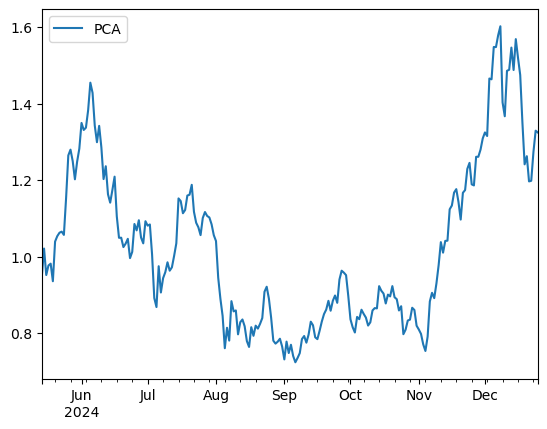

In [96]:
PCA=pd.DataFrame(np.array(list(pca_weight.values())).dot(np.transpose(current_risk.returns)),
                 index=current_risk.returns.index,
                 columns=['PCA'])
PCA=PCA.dropna()
(1+PCA).cumprod().plot()

<Axes: >

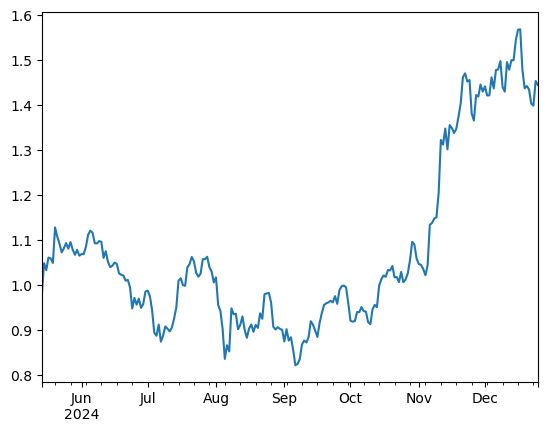

In [97]:
(1+current_risk.returns['BTCUSDT']).cumprod().plot()

In [98]:
comparison=current_risk.returns.copy()
comparison['PCA']=PCA
distances=np.sqrt(np.sum(comparison.apply(lambda y:(y-PCA['PCA'])**2))).sort_values()
distances.iloc[:10]

C:\Users\niroo\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


PCA          0.000000
SOLUSDT      0.397255
ETHUSDT      0.413384
BNBUSDT      0.425613
BTCUSDT      0.445406
JASMYUSDT    0.650408
PEPEUSDT     0.718465
BBUSDT       0.739803
TRXUSDT      0.889175
OMUSDT       0.902863
dtype: float64

<Axes: >

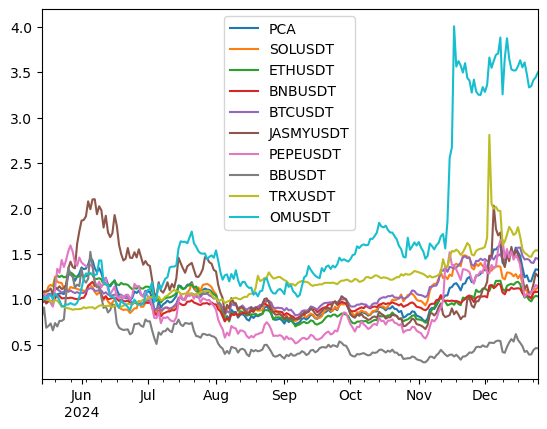

In [99]:
(1+comparison[distances.index[:10]]).cumprod().plot()

## Sensitivity Analysis

In [100]:
beta=(ex_ante_perf.cov()/ex_ante_perf.var())['BTCUSDT'].sort_values(ascending=False)
beta

PEPEUSDT     1.901190
BBUSDT       1.575126
JASMYUSDT    1.268643
SOLUSDT      1.144948
BTCUSDT      1.000000
ETHUSDT      0.959711
OMUSDT       0.875277
BNBUSDT      0.661978
TRXUSDT      0.282443
Name: BTCUSDT, dtype: float64

In [101]:
days=15
beta=(ex_ante_perf.iloc[-days:].cov()/ex_ante_perf.iloc[-days:].var())['BTCUSDT'].sort_values(ascending=False)
beta

JASMYUSDT    2.284565
BBUSDT       1.998090
PEPEUSDT     1.889446
SOLUSDT      1.102536
ETHUSDT      1.065871
BTCUSDT      1.000000
TRXUSDT      0.838762
BNBUSDT      0.708570
OMUSDT       0.431033
Name: BTCUSDT, dtype: float64

### Multilinear Regression

In [102]:
reg=ex_ante_perf.copy().dropna()
reg=reg.iloc[-30:]
reg['PCA']=historical_PCA
X=reg.iloc[:,reg.columns!='PCA'].to_numpy()
Y=reg['PCA'].to_numpy()
columns=list(reg.columns[reg.columns!='PCA'])

beta=np.dot(np.linalg.inv(np.dot(X.T,X)),np.dot(X.T,Y))

In [103]:
table=pd.DataFrame(dict(zip(columns,beta)).values(),index=dict(zip(columns,beta)).keys(),columns=['Beta'])
table.sort_values(by='Beta',ascending=False)

,Beta
ETHUSDT,0.677009
OMUSDT,0.222425
BBUSDT,0.210299
PEPEUSDT,0.097584
JASMYUSDT,0.051130
TRXUSDT,0.038603
SOLUSDT,-0.005606
BTCUSDT,-0.030320
BNBUSDT,-0.079801


### Regression to PCA

In [104]:
reg=ex_ante_perf.copy().dropna()
reg=reg.loc[historical_ptf['Historical Portfolio'].index]

reg['PCA']=historical_PCA
reg['Portfolio']=historical_ptf['Historical Portfolio']
reg=reg.iloc[-15:]
X=reg['PCA'].to_numpy()
Y=reg['Portfolio'].to_numpy()
columns=list(reg.columns[reg.columns!='Porfolio'])

beta=reg.cov()['Portfolio']['PCA']/reg.var()['Portfolio']
beta

1.2338769122280993

In [105]:
reg=ex_ante_perf.copy().dropna()
reg['PCA']=historical_PCA

(reg.cov()['PCA']/reg.var()).sort_values(ascending=False)

BTCUSDT      1.263864
BNBUSDT      1.136522
PCA          1.000000
ETHUSDT      0.998062
SOLUSDT      0.813510
JASMYUSDT    0.421627
PEPEUSDT     0.385292
BBUSDT       0.359109
OMUSDT       0.235307
TRXUSDT      0.201670
dtype: float64

In [106]:
reg=ex_ante_perf.copy().dropna().iloc[-15:]
reg['PCA']=historical_PCA

(reg.cov()['PCA']/reg.var()).sort_values(ascending=False)

BNBUSDT      1.571214
ETHUSDT      1.454285
BTCUSDT      1.454273
SOLUSDT      1.078221
TRXUSDT      1.015870
PCA          1.000000
PEPEUSDT     0.731626
JASMYUSDT    0.591164
BBUSDT       0.486995
OMUSDT       0.441931
dtype: float64

### Correlation Matrix

<Axes: >

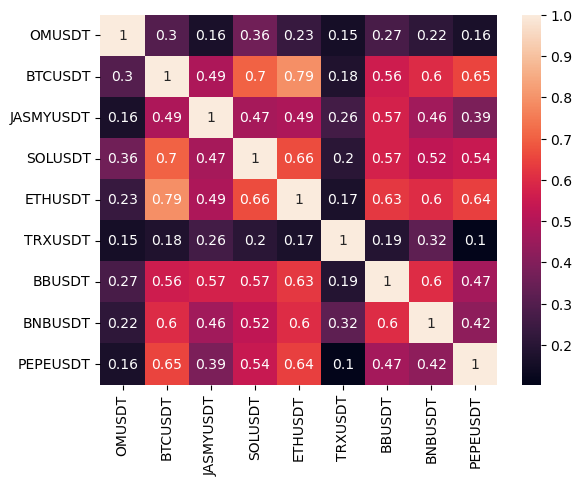

In [107]:
sns.heatmap(ex_ante_perf.corr(),annot=True)

<Axes: >

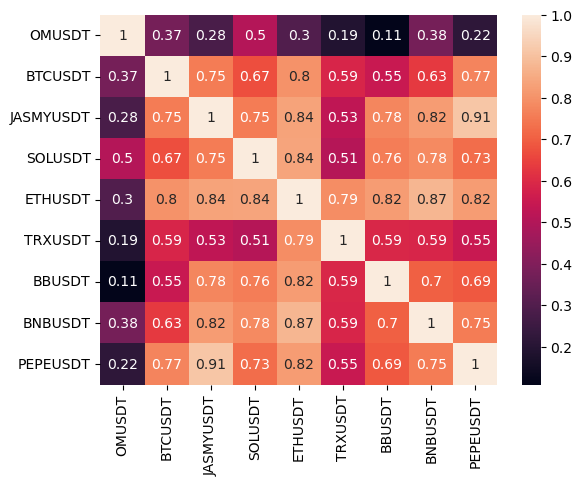

In [108]:
sns.heatmap(ex_ante_perf.iloc[-15:].corr(),annot=True)

## Sliding window optimization

In [109]:
results={}
window=14

for i in range(0,ex_ante_perf_to_use.shape[0]-window+1,window):
    
    try:
        dataset=ex_ante_perf_to_use.iloc[i:i+window]
        risk=RiskAnalysis(dataset)
        date=dataset.index[-1]
        optimal=risk.optimize(objective='sharpe_ratio')     
        results[date]=np.round(optimal,6)
        
    except Exception as e:
        
            pass

rolling_optimization=pd.DataFrame(results,index=ex_ante_perf_to_use.columns).T
rolling_optimization

,OMUSDT,BTCUSDT,JASMYUSDT,SOLUSDT,ETHUSDT,TRXUSDT,BBUSDT,BNBUSDT,PEPEUSDT
2024-05-27,0.000000,0.000000,0.621968,0.000000,0.000000,0.000000,0.000000,0.000000,0.378032
2024-06-10,0.625939,0.000000,0.150852,0.000000,0.000000,0.223209,0.000000,0.000000,0.000000
2024-06-24,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
2024-07-08,0.182528,0.000000,0.000000,0.000000,0.000000,0.817472,0.000000,0.000000,0.000000
2024-07-22,0.133242,0.414562,0.000000,0.112009,0.000000,0.340186,0.000000,0.000000,0.000000
2024-08-05,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2024-08-19,0.000000,0.000000,0.000000,0.000000,0.000000,0.926694,0.000000,0.073306,0.000000
2024-09-02,0.435138,0.000000,0.000000,0.000000,0.000000,0.564862,0.000000,0.000000,0.000000
2024-09-16,0.287440,0.000000,0.000000,0.000000,0.000000,0.000000,0.712560,0.000000,0.000000
2024-09-30,0.176666,0.000000,0.000000,0.000000,0.165949,0.527049,0.000000,0.000000,0.130336


In [110]:
results={}
window=30
days=250
limit=np.where(returns_to_use.columns=='USDCUSDT')[0][0]

for i in range(0,returns_to_use.shape[0]-window+1,window):
    
    try:
        dataset=returns_to_use.iloc[-days:].iloc[i:i+window]
        risk=RiskAnalysis(dataset)
        date=dataset.index[-1]
        optimal=risk.optimize(objective='sharpe_ratio',constraints=[{'type': 'eq', 'fun': lambda weights: weights[limit]-0.0}])
        results[date]=np.round(optimal,6)
        
    except Exception as e:
        
            pass

rolling_optimization=pd.DataFrame(results,index=returns_to_use.columns).T
rolling_optimization

,AAVEUSDT,ADAUSDT,ALGOUSDT,APTUSDT,ARBUSDT,ARUSDT,ATOMUSDT,AVAXUSDT,BCHUSDT,BNBUSDT,...,TRXUSDT,UNIUSDT,USDCUSDT,VETUSDT,WBETHUSDT,WBTCUSDT,WLDUSDT,XLMUSDT,XRPUSDT,XTZUSDT
2024-05-19,0.000000,0.000000,0.0,0.00000,0.0,0.046729,0.0,0.0,0.0,0.0,...,0.690861,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0
2024-06-18,0.000000,0.000000,0.0,0.00000,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0
2024-07-18,0.000000,0.000000,0.0,0.00000,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.786093,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0
2024-08-17,0.525795,0.054776,0.0,0.00000,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0
2024-09-16,0.000000,0.000000,0.0,0.00000,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.032354,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0
2024-10-16,0.000000,0.000000,0.0,0.01023,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.429060,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0
2024-11-15,0.000000,0.000000,0.0,0.00000,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.006299,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0
2024-12-15,0.230591,0.024022,0.0,0.00000,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.14965,0.0
2024-12-25,0.000000,0.000000,0.0,0.00000,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0
